In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import xgboost
from sklearn.model_selection import GroupKFold, KFold
import uuid
import seaborn as sns

In [3]:
## Credits to Sahil Verma
from encoding import FreqeuncyEncoding

In [3]:
train  = pd.read_pickle('train_Sep_29_49Feats.pkl')
test = pd.read_pickle('test_Sep_29_49Feats.pkl')

In [4]:
#train.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)
#test.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)

In [5]:
train['duration'] = train['duration'].dt.days
test['duration'] = test['duration'].dt.days

In [6]:
campaignData = pd.read_csv('campaign_data.csv')
campaignData['start_date'] = pd.to_datetime(campaignData['start_date'], format= '%d/%m/%y')
campaignData['end_date'] = pd.to_datetime(campaignData['end_date'], format= '%d/%m/%y')
campaignData = campaignData.sort_values(by = 'start_date')
testCamp = test.campaign_id.unique()
trainCamp = train.campaign_id.unique()
campaignData['TrainOrTest'] = campaignData['campaign_id'].apply(lambda x : 'Train' if x in trainCamp else 'Test')

In [7]:
train.info(max_cols= 200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 49 columns):
id                              78369 non-null int64
campaign_id                     78369 non-null int64
coupon_id                       78369 non-null int64
customer_id                     78369 non-null int64
redemption_status               78369 non-null int64
campaign_type                   78369 non-null object
duration                        78369 non-null int64
selling_price_mean              78369 non-null float64
selling_price_max               78369 non-null float64
selling_price_min               78369 non-null float64
selling_price_std               78369 non-null float64
other_discount_mean             78369 non-null float64
other_discount_min              78369 non-null float64
other_discount_std              78369 non-null float64
coupon_disc_mean                78369 non-null float64
coupon_disc_min                 78369 non-null float64
coupon_disc_std         

In [8]:
target = 'redemption_status'
cat = ['campaign_type', 'brand_type_mode_cat', 'category_mode_cat', 'brand_type_category_mode_cat', 
      'brand_category_mode_cat', 'age_range', 'marital_status', 'family_size', 'no_of_children']

In [9]:
cat = cat + [x for x in train.columns if x.endswith('cat')]

In [10]:
cat = list(set(cat))

In [11]:
train.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'duration', 'selling_price_mean', 'selling_price_max',
       'selling_price_min', 'selling_price_std', 'other_discount_mean',
       'other_discount_min', 'other_discount_std', 'coupon_disc_mean',
       'coupon_disc_min', 'coupon_disc_std', 'item_id_nunique',
       'item_id_mode_cat', 'brand_mode_cat', 'brand_nunique',
       'brand_type_nunique', 'brand_type_mode_cat', 'category_mode_cat',
       'category_nunique', 'brand_type_category_mode_cat',
       'brand_type_category_nunique', 'quantity_mean', 'quantity_max',
       'day_Of_Week_Mode', 'is_monthEnd_Mean', 'is_monthEnd_Mode',
       'is_monthStart_Mean', 'is_monthStart_Mode', 'disc_perc_mean',
       'disc_perc_max', 'disc_perc_min', 'disc_perc_std',
       'is_coupoun_disc_Mean', 'is_coupoun_disc_Mode',
       'brand_category_mode_cat', 'brand_category_nunique', 'prev_int_count',
       'age_range', 'marital_status', 'rented

In [12]:
numColsToGroupBy = ['duration', 'selling_price_mean', 'selling_price_max',
       'selling_price_min', 'selling_price_std', 'other_discount_mean',
       'other_discount_min', 'other_discount_std', 'coupon_disc_mean',
       'coupon_disc_min'
    ,'quantity_mean', 'quantity_max', 'is_monthEnd_Mean',
       'is_monthStart_Mean', 'disc_perc_mean',
       'is_coupoun_disc_Mean','prev_int_count']

def level_1_group_by_feats(df,cat,num):
    
    ## Credits : Sahil Verma's Github
    ## https://github.com/sahil711/AV/tree/master/Club%20Mahindra%20DataOlympics
    
    df[cat+'_'+num+'_mean']=df[cat].map(dict(df.groupby([cat])[num].mean()))
    df[cat+'_'+num+'_std']=df[cat].map(dict(df.groupby([cat])[num].std()))
    df[cat+'_'+num+'_mean_delta']=df[num]- df[cat+'_'+num+'_mean']
    df[cat+'_'+num+'_mean_ratio']=df[num]/ (1+df[cat+'_'+num+'_mean'])
    return df

In [13]:
All = train.append(test)

In [14]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = cat
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))

In [15]:
combos=[(a,b) for a in numColsToGroupBy for b in cat]
print(len(combos))
for i,combo in enumerate(combos):
    All=level_1_group_by_feats(All,combo[1],combo[0])
    print(i)

187
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186


In [16]:
#All, newCols = one_hot_encoder(All, nan_as_category=True)

In [17]:
fe=FreqeuncyEncoding(categorical_columns=cat,normalize=False,return_df=True)
All=fe.fit_transform(All)

In [18]:
train = All[~All.redemption_status.isnull()]
test = All[All.redemption_status.isnull()]

In [19]:
toDrop = [x for x in train.columns if train[x].nunique() == 1]

In [20]:
notTrainOn = ['id', 'campaign_id']
trainOn = [x for x in train.columns if (x not in notTrainOn ) & (x not in toDrop) & (x!=target)]

In [21]:
gkf = KFold(n_splits=5)

In [22]:
catIndex = [i for i,x in enumerate(trainOn) if x in cat]

In [23]:
oof = np.zeros_like(train[target])
oot = np.zeros_like(test['id']).astype('float')
feature_importance_df = pd.DataFrame()

In [24]:
def getResultSummary(res):
    trainMean = np.mean(list(map(lambda x : x[0], res)))
    validMean = np.mean(list(map(lambda x : x[1], res)))
    trainStd = np.std(list(map(lambda x : x[0], res)))
    validStd = np.std(list(map(lambda x : x[1], res)))
    return {
        
        'Train Mean' : trainMean, 
        'Valid Mean' : validMean, 
        'Train Std'  : trainStd,
        'Valid Std'  : validStd
    }

In [25]:
import lightgbm as lgb

In [26]:
results = []
featureImp = []
i = 0
for train_index, test_index in gkf.split(train[trainOn], train[target]):
    train_X = train.iloc[train_index][trainOn]
    valid_X = train.iloc[test_index][trainOn]
    train_y = train.iloc[train_index][target]
    valid_y = train.iloc[test_index][target]
    dtrain=lgb.Dataset(train_X,label=train_y)
    dvalid=lgb.Dataset(valid_X,label=valid_y)
    params=params={'min_data_in_leaf': 5,
         'num_leaves': 8,
         'learning_rate': 0.026711031423194934,
         'min_child_weight': 0.005238908217059681,
         'colsample_bytree': 0.6044632963222893,
         'bagging_fraction': 0.24901399827744602,
         'min_child_samples': 498.86413570776494,
         'subsample': 0.3650581650899367,
         'reg_lambda': 2.3120762445481233,
         'reg_alpha': 2.7271177752726956,
         'max_depth': 3,
         'scale_pos_weight': 1,
         'objective': 'binary',
         'save_binary': True,
         'seed': 1337,
         'feature_fraction_seed': 1337,
         'bagging_seed': 1337,
         'drop_seed': 1337,
         'data_random_seed': 1337,
         'boosting_type': 'gbdt',
         'verbose': 1,
         'boost_from_average': True,
         'metric': 'auc'}
    model=lgb.train(params,train_set=dtrain,
                valid_sets=[dtrain,dvalid],
                num_boost_round=100000, 
                verbose_eval=1000,
                early_stopping_rounds=100)
    valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)
    train_pred = model.predict(train_X, num_iteration=model.best_iteration)
    
    trainRes = roc_auc_score(train_y, train_pred)
    validRes = roc_auc_score(valid_y, valid_pred)
    
    oof[test_index] = valid_pred
    ootPred = model.predict(test[trainOn], num_iteration=model.best_iteration)
    oot += ootPred / 5
    results.append((trainRes, validRes))
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = trainOn
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    i+=1

Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.989074	valid_1's auc: 0.967151
Early stopping, best iteration is:
[1019]	training's auc: 0.989284	valid_1's auc: 0.96729
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.990753	valid_1's auc: 0.939712
Early stopping, best iteration is:
[1595]	training's auc: 0.994198	valid_1's auc: 0.941479
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.98871	valid_1's auc: 0.960815
Early stopping, best iteration is:
[1131]	training's auc: 0.990088	valid_1's auc: 0.961131
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.989387	valid_1's auc: 0.9665
Early stopping, best iteration is:
[1255]	training's auc: 0.991516	valid_1's auc: 0.967313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[744]	training's auc: 0.986104	valid_1's auc: 0.968139


In [27]:
getResultSummary(results)

{'Train Mean': 0.9902379483670327,
 'Valid Mean': 0.9610706655535664,
 'Train Std': 0.002658460928321468,
 'Valid Std': 0.010113763839124072}

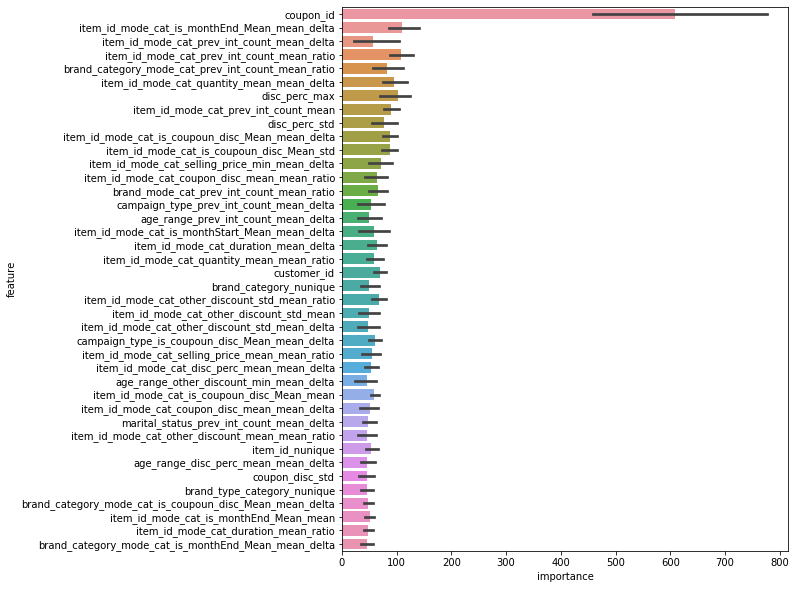

In [28]:
display_importances(feature_importance_df)

In [29]:
def saveStackingFile(prefix):
    oof_ = pd.DataFrame(oof,columns = [prefix])
    oot_ = pd.DataFrame(oot,columns = [prefix])
    print(oof_.shape, oot_.shape)
    oof_.to_csv(prefix + '_train.csv', index = False)
    oot_.to_csv(prefix + '_test.csv', index = False)

In [30]:
saveStackingFile('Feat1_LGBM_Gruped_Cats_FE')

(78369, 1) (50226, 1)


In [35]:
test[target] = oot

In [33]:
fileName = str(uuid.uuid4()).split('-')[-1]

In [34]:
test[['id', target]].to_csv(fileName + '.csv', index = False)

In [35]:
results

[(0.9882174030910144, 0.9664683497889389),
 (0.9954720439683338, 0.9424334434902869),
 (0.9886795761419785, 0.9606190021586363),
 (0.9901786183522268, 0.9673844638782995),
 (0.9844076174850324, 0.9682027263473115)]